<a href="https://colab.research.google.com/github/baoquan25/luongducminh/blob/main/D%E1%BB%B1_%C4%91o%C3%A1n_gi%C3%A1_ch%E1%BB%A9ng_kho%C3%A1n_(1_%C4%91%E1%BA%A7u_v%C3%A0o).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd #đọc dữ liệu
import numpy as np #xử lý dữ liệu
import matplotlib.pyplot as plt #vẽ biểu đồ
from sklearn.preprocessing import MinMaxScaler #chuẩn hóa dữ liệu
from keras.callbacks import ModelCheckpoint #lưu lại huấn luyện tốt nhất
from tensorflow.keras.models import load_model #tải mô hình

#các lớp để xây dựng mô hình
from keras.models import Sequential #đầu vào
from keras.layers import LSTM #học phụ thuộc
from keras.layers import Dropout #tránh học tủ
from keras.layers import Dense #đầu ra

#kiểm tra độ chính xác của mô hình
from sklearn.metrics import r2_score #đo mức độ phù hợp
from sklearn.metrics import mean_absolute_error #đo sai số tuyệt đối trung bình
from sklearn.metrics import mean_absolute_percentage_error #đo % sai số tuyệt đối trung bình

In [ ]:
! pip install vnstock3
from vnstock3 import Vnstock

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.0/93.0 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.1/201.1 kB 6.8 MB/s eta 0:00:00

    Khi tiếp tục sử dụng Vnstock3, bạn xác nhận rằng bạn đã đọc, hiểu và đồng ý với Chính sách quyền riêng tư và Điều khoản, điều kiện về giấy phép sử dụng Vnstock3.

    Chi tiết:

    - Giấy phép sử dụng phần mềm: https://vnstocks.com/docs/tai-lieu/giay-phep-su-dung
    - Chính sách quyền riêng tư: https://vnstocks.com/docs/tai-lieu/chinh-sach-quyen-rieng-tu
    


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Nhập cổ phiếu cần dự đoán

In [ ]:
stock = Vnstock().stock(symbol ='VNINDEX', source= 'VCI')
stock = stock.quote.history(start ='2018-01-01', end ='2024-12-16')
stock = stock.sort_values(by='time')
stock['year'] = stock['time'].dt.year
stock = pd.DataFrame(stock[['time','close']])
stock['close']= stock['close']
stock

2024-12-19 06:25:37 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


,time,close
0,2018-01-02,995.77
1,2018-01-03,1005.67
2,2018-01-04,1019.75
3,2018-01-05,1012.65
4,2018-01-08,1022.90
...,...,...
1733,2024-12-11,1268.86
1734,2024-12-12,1267.35
1735,2024-12-13,1262.57
1736,2024-12-16,1263.79


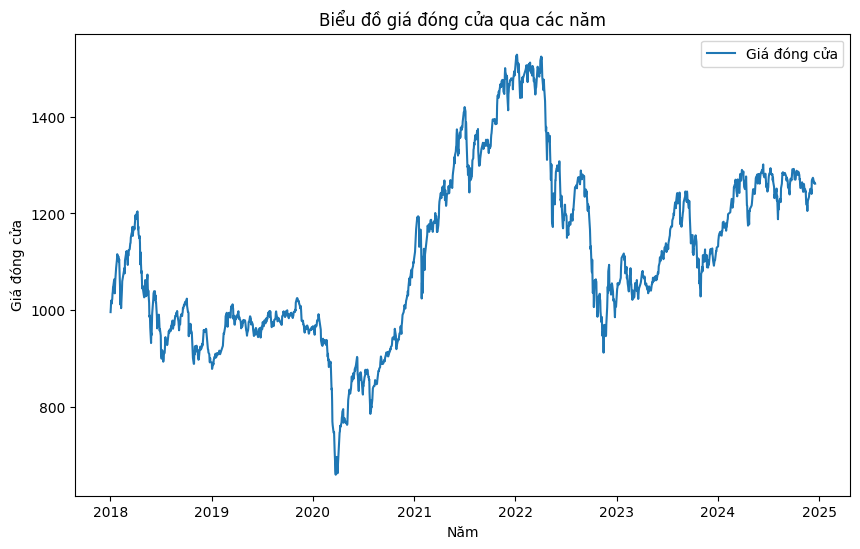

In [ ]:
# Tạo đồ thị giá đóng cửa qua các năm
plt.figure(figsize=(10, 6))
plt.plot(stock['time'],stock['close'], label='Giá đóng cửa')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa qua các năm')
plt.legend()

In [ ]:
#xử lý dữ liệu
stock1 = stock.set_index('time')
stock1

,close
time,
2018-01-02,995.77
2018-01-03,1005.67
2018-01-04,1019.75
2018-01-05,1012.65
2018-01-08,1022.90
...,...
2024-12-11,1268.86
2024-12-12,1267.35
2024-12-13,1262.57


## **Xử lý dữ liệu để đưa vào mô hình**

In [ ]:
#chia tập dữ liệu
data = stock1.values
train_data = data[:1300]
test_data = data[1300:]

#chuẩn hóa dữ liệu
sc = MinMaxScaler(feature_range=(0, 1))
sc_train = sc.fit_transform(data)

#tạo vòng lặp các giá trị
x_train,y_train=[],[]
for i in range(50,len(train_data)):
  x_train.append(sc_train[i-50:i,0]) #lấy 50 giá đóng cửa liên tục
  y_train.append(sc_train[i,0]) # Dự đoán giá trị 'close' (cột đầu tiên)

#xếp dữ liệu thành 1 mảng 2 chiều
x_train = np.array(x_train)
y_train = np.array(y_train)

#xếp lại dữ liệu thành mảng 1 chiều
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
y_train = np.reshape(y_train,(y_train.shape[0],1))

In [ ]:
#xây dựng mô hình
model = Sequential() #tạo lớp mạng cho dữ liệu đầu vào

#lớp 1 LSTM
model.add(LSTM(units=128 ,input_shape=(x_train.shape[1],1),return_sequences=True))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

#Lớp 2 LSTM
model.add(LSTM(units=64))
model.add(Dropout(0.2)) #loại bỏ 1 số đơn vị tránh học tủ (overfitting)

model.add(Dense(1)) #output đầu ra 1 chiều

#đo sai số tuyệt đối trung bình có sử dụng trình tối ưu hóa adam
model.compile(loss='mean_absolute_error',optimizer='adam')

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


In [ ]:
#huấn luyện mô hình
save_model = "/content/drive/MyDrive/model1.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
model.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2, callbacks=[best_model])

Epoch 1/100

Epoch 1: loss improved from inf to 0.12929, saving model to /content/drive/MyDrive/model1.keras
25/25 - 7s - 283ms/step - loss: 0.1293
Epoch 2/100

Epoch 2: loss improved from 0.12929 to 0.05135, saving model to /content/drive/MyDrive/model1.keras
25/25 - 3s - 108ms/step - loss: 0.0514
Epoch 3/100

Epoch 3: loss improved from 0.05135 to 0.04653, saving model to /content/drive/MyDrive/model1.keras
25/25 - 3s - 104ms/step - loss: 0.0465
Epoch 4/100

Epoch 4: loss improved from 0.04653 to 0.04466, saving model to /content/drive/MyDrive/model1.keras
25/25 - 3s - 103ms/step - loss: 0.0447
Epoch 5/100

Epoch 5: loss improved from 0.04466 to 0.04270, saving model to /content/drive/MyDrive/model1.keras
25/25 - 7s - 279ms/step - loss: 0.0427
Epoch 6/100

Epoch 6: loss did not improve from 0.04270
25/25 - 3s - 128ms/step - loss: 0.0434
Epoch 7/100

Epoch 7: loss improved from 0.04270 to 0.04260, saving model to /content/drive/MyDrive/model1.keras
25/25 - 3s - 104ms/step - loss: 0.04

In [ ]:
#dữ liệu train
y_train = sc.inverse_transform(y_train) #giá thực
final_model = load_model("/content/drive/MyDrive/model1.keras")
y_train_predict = final_model.predict(x_train) #dự đoán giá đóng cửa trên tập đã train
y_train_predict = sc.inverse_transform(y_train_predict) #giá dự đoán

40/40 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step


In [ ]:
#xử lý dữ liệu test
test = stock1[len(train_data)-50:]  # Lấy phần dữ liệu từ DataFrame
test = test.values.reshape(-1, 1)  # Chuyển DataFrame thành mảng NumPy và reshape

# Loại bỏ các hàng chứa NaT trong test trước khi áp dụng transform
# Thay thế np.isnan bằng pd.isnull để xử lý các kiểu dữ liệu khác, bao gồm cả NaT
test = test[~pd.isnull(test).any(axis=1)]

sc_test = sc.transform(test)

x_test = []
for i in range(50,test.shape[0]):
  x_test.append(sc_test[i-50:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

#dữ liệu test
y_test = data[1300:] #giá thực
y_test_predict = final_model.predict(x_test)
y_test_predict = sc.inverse_transform(y_test_predict) #giá dự đoán

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


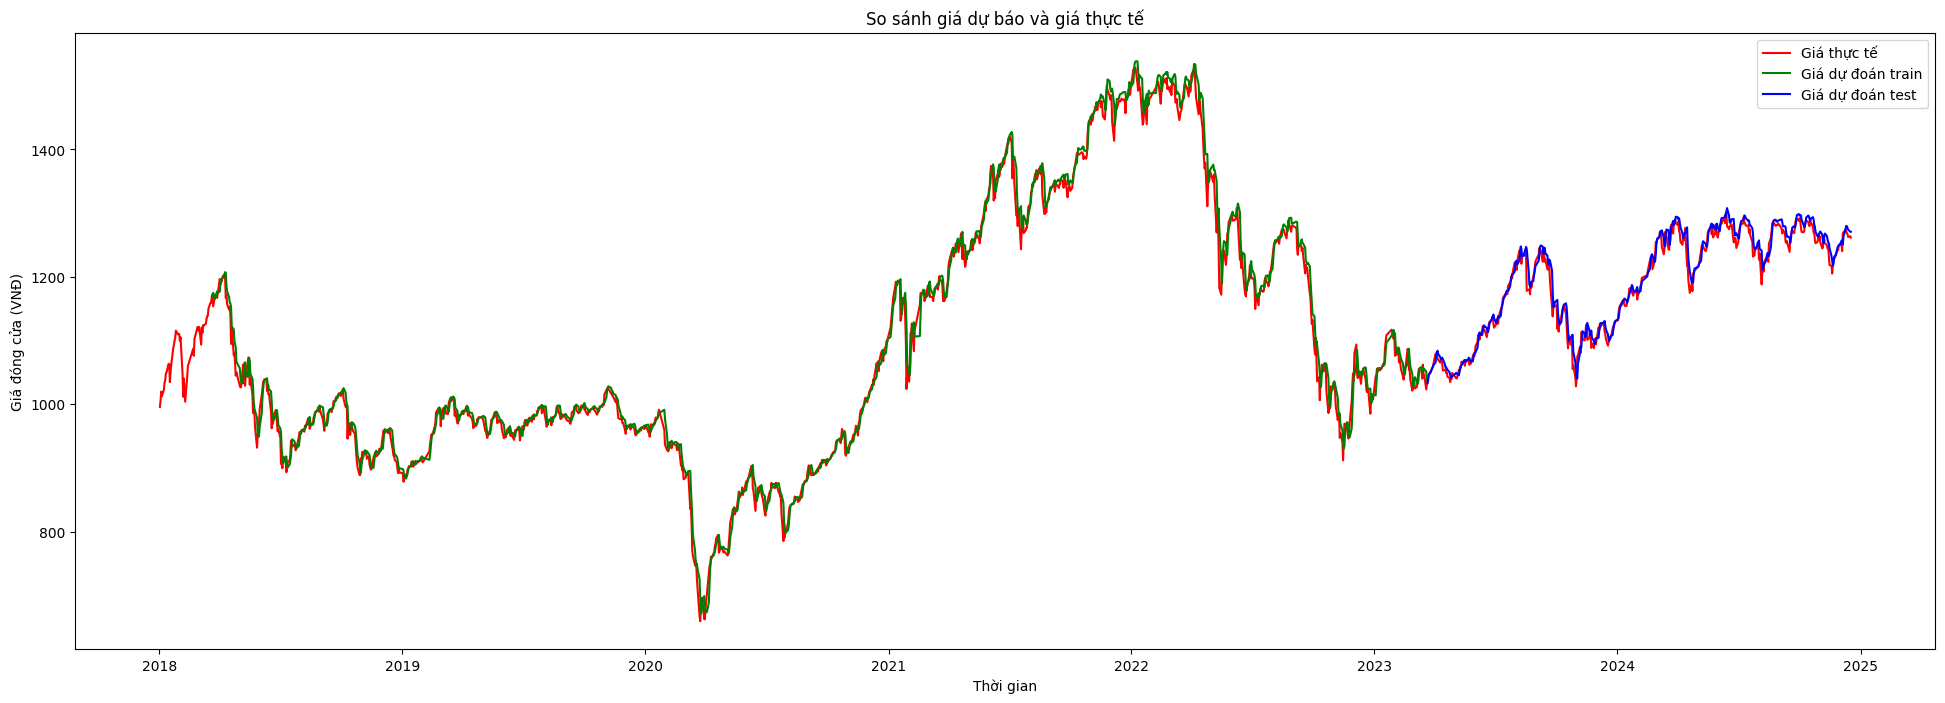

In [ ]:
#lập biểu đồ so sánh
train_data1 = stock1[50:1300]
test_data1 = stock1[1300:]

plt.figure(figsize=(24,8))
plt.plot(stock1,label='Giá thực tế',color='red') #đường giá thực
train_data1['Dự đoán'] = y_train_predict #thêm dữ liệu
plt.plot(train_data1['Dự đoán'],label='Giá dự đoán train',color='green') #đường giá dự báo train
test_data1['Dự đoán'] = y_test_predict #thêm dữ liệu
plt.plot(test_data1['Dự đoán'],label='Giá dự đoán test',color='blue') #đường giá dự báo test
plt.title('So sánh giá dự báo và giá thực tế') #đặt tên biểu đồ
plt.xlabel('Thời gian') #đặt tên hàm x
plt.ylabel('Giá đóng cửa (VNĐ)') #đặt tên hàm y
plt.legend() #chú thích
plt.show()

Nhập số ngày muốn dự đoán: 10
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


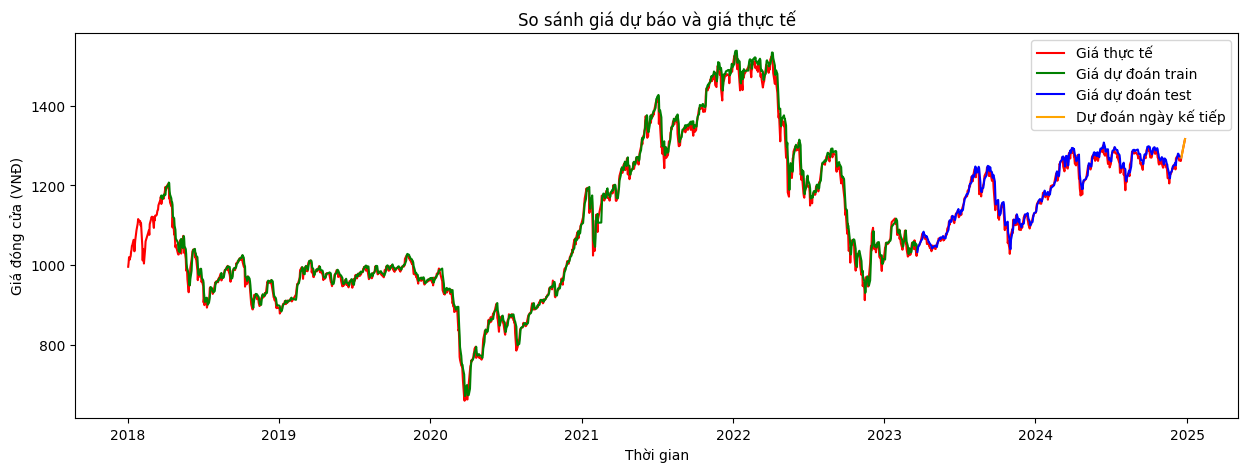

,time,close
1737,2024-12-17,1261.720000
1738,2024-12-18,1269.953003
1739,2024-12-19,1274.566895
1740,2024-12-20,1280.253296
1741,2024-12-21,1285.869995
1742,2024-12-22,1291.223755
1743,2024-12-23,1296.388550
1744,2024-12-24,1301.457642
1745,2024-12-25,1306.493286
1746,2024-12-26,1311.531738


In [ ]:
date = int(input("Nhập số ngày muốn dự đoán: "))

# Lấy ngày kế tiếp sau ngày cuối cùng trong tập dữ liệu để dự đoán
next_date = [stock['time'].iloc[-1] + pd.Timedelta(days=i+1) for i in range(date)]

# Chuyển đổi ngày kế tiếp sang dạng datetime
next_date = pd.to_datetime(next_date)

x_next = sc_train[-50:, 0]  # Lấy 50 giá trị cuối cùng từ dữ liệu đã chuẩn hóa
predicted_prices = []  # Danh sách để lưu kết quả dự đoán

for i in range(date):  # Dự đoán ngày tiếp theo
    # Reshape dữ liệu thành dạng phù hợp cho LSTM
    x_input = np.array([x_next])
    x_input = np.reshape(x_input, (x_input.shape[0], x_input.shape[1], 1))

    # Dự đoán giá ngày kế tiếp
    y_next_predict = final_model.predict(x_input)

    # Đưa giá trị dự đoán ngược lại thành giá trị gốc (inverse transform)
    y_next_predict_original = sc.inverse_transform(y_next_predict)[0][0]
    predicted_prices.append(y_next_predict_original)

    # Cập nhật x_next để dự đoán cho ngày tiếp theo
    x_next = np.append(x_next[1:], y_next_predict)

# Thêm dữ liệu dự đoán của ngày kế tiếp vào DataFrame
stock_next = pd.DataFrame({'time': next_date, 'close': predicted_prices})
stock1 = pd.concat([stock, stock_next],ignore_index=True)

# Vẽ biểu đồ mới với dự đoán cho ngày kế tiếp
plt.figure(figsize=(15, 5))
plt.plot(stock1['time'], stock1['close'], label='Giá thực tế', color='red')
plt.plot(train_data1.index, train_data1['Dự đoán'], label='Giá dự đoán train', color='green')
plt.plot(test_data1.index, test_data1['Dự đoán'], label='Giá dự đoán test', color='blue')
plt.plot(next_date, predicted_prices, color='orange', label='Dự đoán ngày kế tiếp')
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa (VNĐ)')
plt.title('So sánh giá dự báo và giá thực tế')
plt.legend()
plt.show()

# Bảng dự đoán
stock1.tail(date + 1)